In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from bem import geometry as gm
from bem import observations
import bem.greensfunctions as GF

# Define the coordinates of the rectangular box domain
H = 1 # vertical dimension
L = 3*H # horizontal dimension becomes 2*L because of symmetry
ngrid = 100 # number of points to mesh H

# Radius,depth of fluid-filled material (this is located at x = 0)
# Vary x-radius of the cavity
Nrun = 5
V_radiusx = np.linspace(0.1,0.9,Nrun)*H
V_radiusz = V_radiusx*0 + 0.2*H

V_z0 = -0.5*H
pval = 100*H # uniform pressure inside the fluid-filled cavity
nellipse = 41 # number of points to mesh the ellipse boundary


In [53]:
def setup_BEM_matrices(rcv,bnd,bcindices,bcvals,bcindex_top,bcindex_bot,bcindex_left,bcindex_right,bcindex_int):
    # compute traction kernels
    KKss,KKns,KKsn,KKnn = GF.compute_tractionkernel(rcv,rcv)
    KLss,KLns,KLsn,KLnn = GF.compute_tractionkernel(rcv,bnd)
    LKss,LKns,LKsn,LKnn = GF.compute_tractionkernel(bnd,rcv)
    LLss,LLns,LLsn,LLnn = GF.compute_tractionkernel(bnd,bnd)
    """
    K - outer boundary
    L - internal boundary
    LK - internal boundary on outside boundary
    KL - outside boundary on internal boundary
    sn - shear traction due to normal slip
    ns - normal traction due to shear slip
    """
    # compute displacement kernels
    G_KK_xs,G_KK_zs,G_KK_xn,G_KK_zn = GF.compute_displacementkernel(rcv,rcv)
    G_LK_xs,G_LK_zs,G_LK_xn,G_LK_zn = GF.compute_displacementkernel(bnd,rcv)

    """
    assemble boundary conditions as right hand side vector
    s - s (traction) and x (displacement)
    n - n (traction) and z (displacement)"""
    rhs_s = np.zeros((rcv.N+bnd.N,1))
    rhs_n = np.zeros((rcv.N+bnd.N,1))


    # specify boundary conditions
    bc_top_s = bcvals[0]*np.ones_like(np.where(bcindex_top)) 
    bc_top_n = bcvals[1]*np.ones_like(np.where(bcindex_top)) 
    rhs_s[bcindex_top,0] = bc_top_s
    rhs_n[bcindex_top,0] = bc_top_n

    bc_bot_s = bcvals[2]*np.ones_like(np.where(bcindex_bot)) 
    bc_bot_n = bcvals[3]*np.ones_like(np.where(bcindex_bot)) 
    rhs_s[bcindex_bot,0] = bc_bot_s
    rhs_n[bcindex_bot,0] = bc_bot_n

    bc_left_s = bcvals[4]*np.ones_like(np.where(bcindex_left)) 
    bc_left_n = bcvals[5]*np.ones_like(np.where(bcindex_left)) 
    rhs_s[bcindex_left,0] = bc_left_s
    rhs_n[bcindex_left,0] = bc_left_n

    bc_right_s = bcvals[6]*np.ones_like(np.where(bcindex_right)) 
    bc_right_n = bcvals[7]*np.ones_like(np.where(bcindex_right))
    rhs_s[bcindex_right,0] = bc_right_s
    rhs_n[bcindex_right,0] = bc_right_n

    bc_int_s = bcvals[8]*np.ones_like(np.where(bcindex_int)) 
    bc_int_n = bcvals[9]*np.ones_like(np.where(bcindex_int)) 
    rhs_s[bcindex_int,0] = bc_int_s
    rhs_n[bcindex_int,0] = bc_int_n

    rhs = np.concatenate((rhs_s, rhs_n))

    # Construct the matrices for linear inverse problem
    # s - s (traction) and x (displacement)
    # n - n (traction) and z (displacement)
    As_s = np.zeros((rcv.N+bnd.N,rcv.N+bnd.N)) 
    An_s = np.zeros((rcv.N+bnd.N,rcv.N+bnd.N)) 

    As_n = np.zeros((rcv.N+bnd.N,rcv.N+bnd.N))
    An_n = np.zeros((rcv.N+bnd.N,rcv.N+bnd.N))

    # TOP BC
    if bcindices[0]==1:# for shear traction bc
        As_s[bcindex_top] = np.concatenate((KKss[bcindex_top[0:rcv.N]],LKss[bcindex_top[0:rcv.N]]),axis=1)
        As_n[bcindex_top] = np.concatenate((KKsn[bcindex_top[0:rcv.N]],LKsn[bcindex_top[0:rcv.N]]),axis=1)    
    else:# for x displacement bc
        As_s[bcindex_top] = G_xs[bcindex_top[0:rcv.N]] 

    if bcindices[1]==1: # for normal traction bc
        An_s[bcindex_top] = np.concatenate((KKns[bcindex_top[0:rcv.N]],LKns[bcindex_top[0:rcv.N]]),axis=1)
        An_n[bcindex_top] = np.concatenate((KKnn[bcindex_top[0:rcv.N]],LKnn[bcindex_top[0:rcv.N]]),axis=1)
    else: # for z displacement bc
        An_s[bcindex_top] = G_zs[bcindex_top[0:rcv.N]]

    # BOTTOM BC
    if bcindices[2]==1:# for shear traction bc
        As_s[bcindex_bot] = np.concatenate((KKss[bcindex_bot[0:rcv.N]],LKss[bcindex_bot[0:rcv.N]]),axis=1)
        As_n[bcindex_bot] = np.concatenate((KKsn[bcindex_bot[0:rcv.N]],LKsn[bcindex_bot[0:rcv.N]]),axis=1)
    else:# for x displacement bc
        As_s[bcindex_bot] = Gx_s[bcindex_bot]

    if bcindices[3]==1:# for normal traction bc
        An_s[bcindex_bot] = np.concatenate((KKns[bcindex_bot[0:rcv.N]],LKns[bcindex_bot[0:rcv.N]]),axis=1)
        An_n[bcindex_bot] = np.concatenate((KKnn[bcindex_bot[0:rcv.N]],LKnn[bcindex_bot[0:rcv.N]]),axis=1)
    else:# for z displacement bc
        An_s[bcindex_bot] = np.concatenate((G_KK_zs[bcindex_bot[0:rcv.N]],G_LK_zs[bcindex_bot[0:rcv.N]]),axis=1)
        An_n[bcindex_bot] = np.concatenate((G_KK_zn[bcindex_bot[0:rcv.N]],G_LK_zn[bcindex_bot[0:rcv.N]]),axis=1)

    # LEFT BC
    if bcindices[4]==0:# for x displacement BC
        As_s[bcindex_left] = np.concatenate((G_KK_xs[bcindex_left[0:rcv.N]],G_LK_xs[bcindex_left[0:rcv.N]]),axis=1)
        As_n[bcindex_left] = np.concatenate((G_KK_xn[bcindex_left[0:rcv.N]],G_LK_xn[bcindex_left[0:rcv.N]]),axis=1)
    else:# shear traction BC
        As_s[bcindex_left] = Ks_s[bcindex_left]

    if bcindices[5]==0: # for z displacement bc
        An_s[bcindex_left] = np.concatenate((G_KK_zs[bcindex_left[0:rcv.N]],G_LK_zs[bcindex_left[0:rcv.N]]),axis=1)
        An_n[bcindex_left] = np.concatenate((G_KK_zn[bcindex_left[0:rcv.N]],G_LK_zn[bcindex_left[0:rcv.N]]),axis=1)
    else: # normal traction  BC      
        An_s[bcindex_left] = Kn_s[bcindex_left]

    # RIGHT BC
    if bcindices[6]==0: # x displacement BC
        As_s[bcindex_right] = np.concatenate((G_KK_xs[bcindex_right[0:rcv.N]],G_LK_xs[bcindex_right[0:rcv.N]]),axis=1)
        As_n[bcindex_right] = np.concatenate((G_KK_xn[bcindex_right[0:rcv.N]],G_LK_xn[bcindex_right[0:rcv.N]]),axis=1)
    else:
        As_s[bcindex_right] = Ks_s[bcindex_right]

    if bcindices[7]==0: # z displacement BC
        An_s[bcindex_right] = np.concatenate((G_KK_zs[bcindex_right[0:rcv.N]],G_LK_zs[bcindex_right[0:rcv.N]]),axis=1)
        An_n[bcindex_right] = np.concatenate((G_KK_zn[bcindex_right[0:rcv.N]],G_LK_zn[bcindex_right[0:rcv.N]]),axis=1)
    else:
        An_s[bcindex_right] = Kn_s[bcindex_right]

    # INTERNAL BOUNDARY
    if bcindices[8]==1: # shear traction BC
        As_s[bcindex_int] = np.concatenate((KLss[bcindex_int[rcv.N:]],LLss[bcindex_int[rcv.N:]]),axis=1)
        As_n[bcindex_int] = np.concatenate((KLsn[bcindex_int[rcv.N:]],LLsn[bcindex_int[rcv.N:]]),axis=1)    
    else:# for x displacement bc
        As_s[bcindex_int] = G_xs[bcindex_int[0:rcv.N]] 

    if bcindices[9]==1: # normal traction BC
        An_s[bcindex_int] = np.concatenate((KLns[bcindex_int[rcv.N:]],LLns[bcindex_int[rcv.N:]]),axis=1)
        An_n[bcindex_int] = np.concatenate((KLnn[bcindex_int[rcv.N:]],LLnn[bcindex_int[rcv.N:]]),axis=1)    
    else:# for z displacement bc
        As_s[bcindex_int] = G_xs[bcindex_int[0:rcv.N]] 

    # assemble big matrix
    A = np.block([[As_s, As_n], [An_s, An_n]])

    return A,rhs
    

/var/folders/3b/bxk9vzw92vvffs96mcpb05nm0000gn/T/ipykernel_96742/3808128977.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('magma')


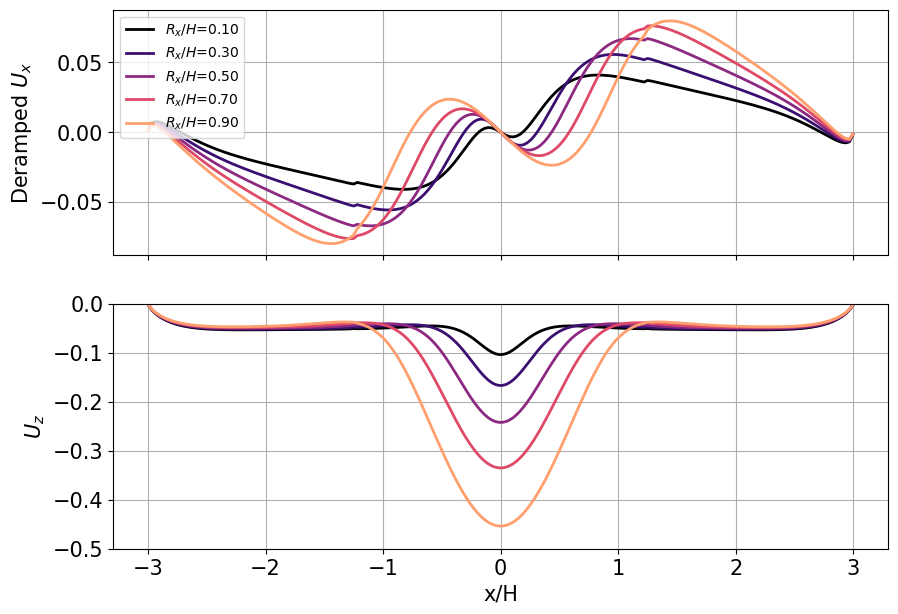

In [54]:
# boundary conditions
"""specify whether displacement or traction BCs
1 - traction BC
0 - displacement BC
[top_s,top_n,
bot_s,bot_n,
left_s,left_n,
right_s,right_n
internal_s,internal_n]
"""
bcindices = np.array([1,1,1,1,\
                      0,0,0,0,\
                        1,1])
# corresponding values at each of those boundaries
bcvals = np.array([0,0,0,0,\
                   -1,0,1,0,\
                    0,pval])


# meshing
corners = np.array([[-L, 0], [L, 0], [L, -H], [-L, -H], [-L, 0]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt((corners[i,0]-corners[(i+1),0])**2 + (corners[i,1]-corners[(i+1),1])**2)
    xi = np.linspace(corners[i][0], corners[(i + 1) % 4][0], num=round(lsegment*ngrid/H), endpoint=False)
    zi = np.linspace(corners[i][1], corners[(i + 1) % 4][1], num=round(lsegment*ngrid/H), endpoint=False)
    x.append(xi)
    z.append(zi)
x.append(corners[0,0])
z.append(corners[0,1])

x = np.hstack(x)
z = np.hstack(z)

# create a geometry object with those nodes
rcv = gm(x,z)

# set colormap for plotting
color_map = cm.get_cmap('magma')

# plot figures
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches((10,7))

for i in range(Nrun):
    # mesh an ellpise at (0,V_z0) with 2 radii specified
    theta = np.linspace(0,-2*np.pi,nellipse)
    x = V_radiusx[i]*np.cos(theta)
    z = V_radiusz[i]*np.sin(theta) + V_z0

    # create geometry object with those nodes
    bnd = gm(x,z)
    
    # label boundaries
    bcindex_ext = (bnd.z>0) # label the internal boundary as false
    bcindex_top = np.concatenate(((rcv.z==0),bcindex_ext))
    bcindex_bot = np.concatenate(((rcv.z==-H),bcindex_ext))
    bcindex_left = np.concatenate(((rcv.x==-L),bcindex_ext))
    bcindex_right = np.concatenate(((rcv.x==L),bcindex_ext))
    bcindex_int = np.concatenate(((rcv.z>100),(~bcindex_ext)))

    A,rhs = setup_BEM_matrices(rcv,bnd,bcindices,bcvals,bcindex_top,bcindex_bot,bcindex_left,bcindex_right,bcindex_int)
    
    # Solve linear system of equations
    solvec,_,_,_ = np.linalg.lstsq(A, rhs, rcond=None)

    # extract solution into slip components for all boundaries
    slip_s = solvec[0:rcv.N+bnd.N,0]
    slip_n = solvec[rcv.N+bnd.N:,0]

    # compute displacements in the medium
    xvec = np.linspace(-0.999*L,0.999*L,200)
    zvec = xvec*0 -1e-6*H

    # create observer object
    obs = observations(xvec,zvec)

    # compute displacement kernels
    G_Kox_s,G_Koz_s,G_Kox_n,G_Koz_n = GF.compute_displacementkernel(rcv,obs)
    G_Lox_s,G_Loz_s,G_Lox_n,G_Loz_n = GF.compute_displacementkernel(bnd,obs)

    # compute internal displacements
    x_obs = G_Kox_s@slip_s[0:rcv.N] + G_Kox_n@slip_n[0:rcv.N] + G_Lox_s@slip_s[rcv.N:] + G_Lox_n@slip_n[rcv.N:]
    z_obs = G_Koz_s@slip_s[0:rcv.N] + G_Koz_n@slip_n[0:rcv.N] + G_Loz_s@slip_s[rcv.N:] + G_Loz_n@slip_n[rcv.N:]

    ax1.plot(obs.x,x_obs-1/L*obs.x,'-',color=color_map(i/Nrun),label=f'$R_x/H$={V_radiusx[i]:.2f}',linewidth=2)
    ax2.plot(obs.x,z_obs,'-',color=color_map(i/Nrun),linewidth=2)

ax1.grid()
ax1.legend()
ax1.tick_params(axis='both', labelsize=15)
ax1.set_ylabel('Deramped $U_x$',fontsize=15)
ax2.grid()
ax2.tick_params(axis='both', labelsize=15)
ax2.set_ylabel('$U_z$',fontsize=15)
ax2.set_xlabel('x/H',fontsize=15)
ax2.set_ylim((-0.5,0))
plt.show()

